# Classic optimizer convergence studies

We want to test the hypotesis that the VQE algorithm needs a certain amount of shots to start converging due to the fact that the classical optimizer requires a minimum information to correctly build the cost function gradient.

We will:
- create a VQE circuit;
- choose a set of parameters;
- measure the circuit a large amount of times (i.e. 10000). We will consider the resulting distribution as the real eigenstates composition of the circuit. The cost function obtained will be consider as the true cost function;
- measure the same circuit a smaller amount of times (i.e. 1, 2, 4, 8, 12, 16, 24, 32, 64, 128, 256). Repeat each measurement 100 times, considering the average cost function and comparing it and the eigenstate composition with the real ones.

In [1]:
# To import all the functions defined in Functions.py
from  Functions import *

In [ ]:
# Create random max-cut problem 
M = random_graph_producer(n_vert = 10, n_edge = 22, seed = 2000, verbosity = True)

In [ ]:
# Get the solution
brute_solution, brute_cost, eig = brute_force_solver(M, verbosity=True)

In [ ]:
# First example: initial ansatz angles

# Circuit parameters
N_QBITS = 10
DEPTH   = 2

# Initial rotation angles
theta_0       = np.repeat(PI/2, N_QBITS)
theta_0.shape = (1, N_QBITS)
theta_1       = np.zeros((DEPTH, N_QBITS))
x_0           = np.concatenate((theta_0, theta_1), axis = 0) 

my_circuit = VQE_circuit(x_0, N_QBITS, DEPTH)

my_circuit.draw(output = "mpl")

# Execute the circuit on a simulator
job = execute(my_circuit, 
              backend = Aer.get_backend('qasm_simulator'), 
              shots   = 50000)

real_result = job.result()

real_eigenstates = real_result.get_counts(my_circuit)

real_cost = cost_function_C(real_eigenstates, M)
real_eigenstates

In [ ]:
# Repeat with fewer shots
SHOTS = 2

# Initialize parameters
cost_1        = []
eigenstates_1 = []

# Initial rotation angles
theta_0       = np.repeat(PI/2, N_QBITS)
theta_0.shape = (1, N_QBITS)
theta_1       = np.zeros((DEPTH, N_QBITS))
x_0           = np.concatenate((theta_0, theta_1), axis = 0) 

for i in range(100):
    job = execute(my_circuit, 
                  backend = Aer.get_backend('qasm_simulator'), 
                  shots   = SHOTS)

    result = job.result()

    eigenstates = result.get_counts(my_circuit)

    cost = cost_function_C(eigenstates, M)
    
    eigenstates_1.append(eigenstates)
    cost_1.append(cost)
    
print(np.mean(cost_1))
print(np.std(cost_1))

In [10]:
# PI declaration
import numpy as np
PI = np.pi

# Define a function
def convergence_tester(n_qbits, n_edges, depth, 
                       shots, repetitions = 100,
                       reference_shots = 50000,
                       x0 = "random"):
    """Test the convergence of a circuit vs number of measurements.
    
    The function creates a random max-cut problem of a given number
    of vertices and edges and a VQE circuit of some given parameters
    to solve it. It returns the expected cost function obtained with 
    a high number of shots and the cost function distribution
    obtained repeating the measurement with a smaller number of shots.
    The circuit rotation angles can be passed as input, otherwise they 
    will be random.
    
    Parameters
    n_qbits: circuit number of qbits and equivalently, max-cut graph 
        vertices;
    n_edges: max-cut graph number of edges;
    depth: VQE circuit depth;
    shots: smaller number of shots (for the repeated measurement);
    repetitions: number of repeated measurements with small number 
        of shots;
    reference_shots: number of shots used to compute the reference
        cost function value;
    x0: circuit rotation angles.
    """
    
    # Create random max-cut problem 
    M = random_graph_producer(n_vert = n_qbits, 
                              n_edge = n_edges, 
                              seed = 2000, 
                              verbosity = False)
    
    # Get the solution
    brute_solution, brute_cost, eig = brute_force_solver(M, verbosity = False)
        
    # Circuit rotation angles
    if x0 == "random":
        print("Random angle choice")
        theta_0       = np.random.rand(n_qbits)*2*PI
        theta_0.shape = (1, n_qbits)
        theta_1       = np.random.rand(depth, n_qbits)*2*PI
        x0            = np.concatenate((theta_0, theta_1), axis = 0) 
        
    # Create the VQE circuit
    circuit = VQE_circuit(x0, n_qbits, depth)

    # Execute the circuit with large amount of shots
    reference_job = execute(circuit, 
                            backend = Aer.get_backend('qasm_simulator'), 
                            shots   = reference_shots)

    # Extract the results
    reference_result = reference_job.result()

    # Get eigenstates distribution - as a dictionary
    reference_eigenstates = reference_result.get_counts(circuit)

    # Get the cost function
    reference_cost = cost_function_C(reference_eigenstates, M)

    # Initialize output
    small_eigenstates = []
    small_cost        = []
    
    # Now execute several times the circuit, but using a smaller 
    # number of shots
    for i in range(repetitions):
        job = execute(circuit, 
                      backend = Aer.get_backend('qasm_simulator'), 
                      shots   = shots)
        
        # Get the results
        result = job.result()
        eigenstates = result.get_counts(circuit)
        cost = cost_function_C(eigenstates, M)
    
        # Append the results to the output
        small_eigenstates.append(eigenstates)
        small_cost.append(cost)
        
    # Finally, the output
    return reference_eigenstates, reference_cost, small_eigenstates, small_cost

# First test


Best solution = [[0, 1, 0, 1, 0], [1, 0, 1, 0, 1]] cost = 32.0


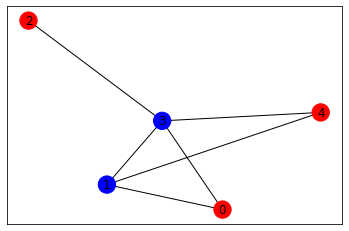

In [45]:
# Create random max-cut problem 
M = random_graph_producer(n_vert = 5, n_edge = 6, seed = 2000, verbosity = False)

# Get the solution
brute_solution, brute_cost, eig = brute_force_solver(M, verbosity = True)

In [33]:
ref_eig, ref_cost, test_eig, test_cost = convergence_tester(n_qbits = 5, 
                                                            n_edges = 6, 
                                                            depth = 2, 
                                                            shots = 2)

Random angle choice


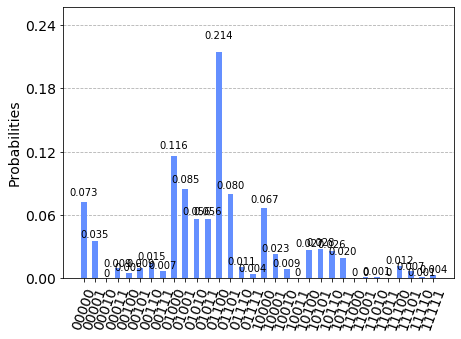

In [34]:
# Plot the result
from qiskit.visualization import plot_histogram

plot_histogram(ref_eig)

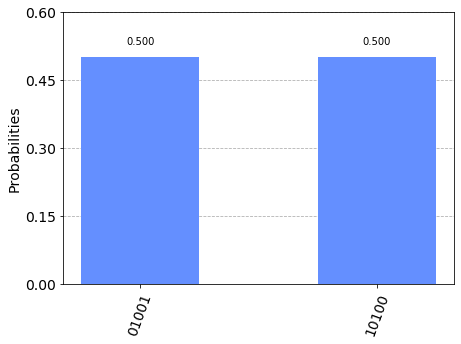

In [35]:
plot_histogram(test_eig[0])

In [36]:
ref_cost

-20.1164

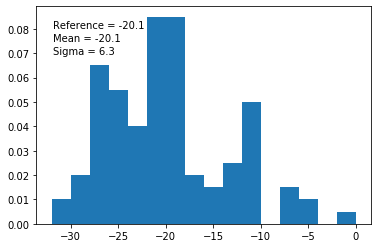

In [37]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

plt.hist(test_cost, bins = int(brute_cost / 2), range = (-brute_cost, 0), density = True)
ax.text(0.05, 0.90,"Reference = {:.1f}".format(ref_cost), transform=ax.transAxes)
ax.text(0.05, 0.84,"Mean = {:.1f}".format(np.mean(test_cost)), transform=ax.transAxes)
ax.text(0.05, 0.78,"Sigma = {:.1f}".format(np.std(test_cost)), transform=ax.transAxes)
plt.show()

# RY ansatz

In [115]:
n_qbits = 10
n_edge  = 22
depth   = 2

# Create random max-cut problem 
M = random_graph_producer(n_vert = n_qbits, 
                          n_edge = n_edge, 
                          seed = 2000, 
                          verbosity = False)

# Get the solution
brute_solution, brute_cost, eig = brute_force_solver(M, verbosity = False)

theta_0       = np.repeat(PI/2, n_qbits)
theta_0.shape = (1, n_qbits)
theta_1       = np.zeros((depth, n_qbits))
x_0           = np.concatenate((theta_0, theta_1), axis = 0) 

ref_eig, ref_cost, test_eig, test_cost = convergence_tester(n_qbits     = n_qbits, 
                                                            n_edges     = n_edge, 
                                                            depth       = depth, 
                                                            shots       = 2,
                                                            x0          = x_0,
                                                            repetitions = 1000)

/home/nicolo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


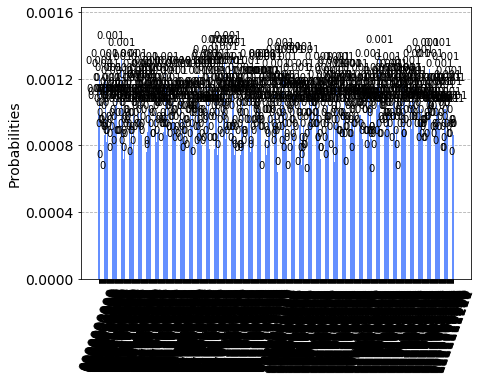

In [116]:
# Plot the result
from qiskit.visualization import plot_histogram

plot_histogram(ref_eig)

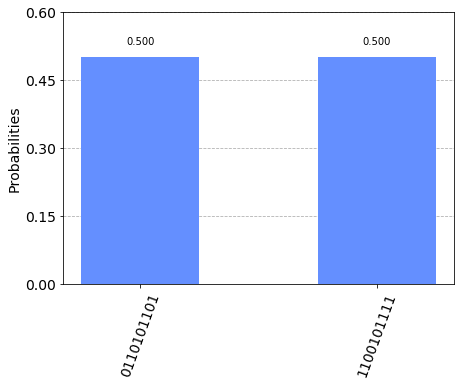

In [117]:
plot_histogram(test_eig[900])

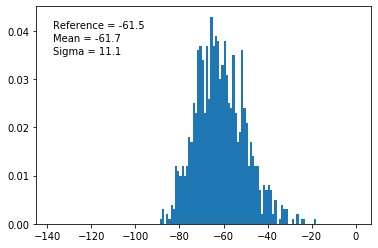

In [118]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

y, x, _ = plt.hist(test_cost, 
         bins = int(1.5*brute_cost), 
         range = (-1.5*brute_cost, 0), 
         density = True)

ax.text(0.05, 0.90, "Reference = {:.1f}".format(ref_cost), 
        transform=ax.transAxes)
ax.text(0.05, 0.84, "Mean = {:.1f}".format(np.mean(test_cost)), 
        transform=ax.transAxes)
ax.text(0.05, 0.78, "Sigma = {:.1f}".format(np.std(test_cost)), 
        transform=ax.transAxes)

plt.show()